<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [85]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-10-13 10:30:03--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2019-10-13 10:30:04 (304 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [35]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: \ ^C
failed

CondaError: KeyboardInterrupt



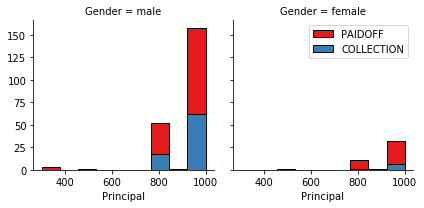

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

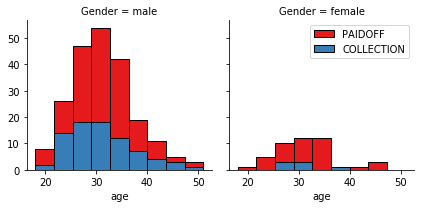

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

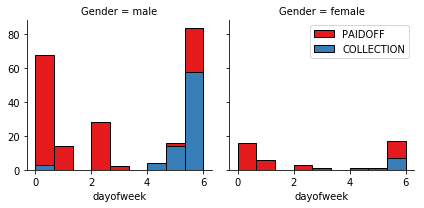

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Let's define feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
print(y[0:8])


y_int=df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF']


## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

## Construct Training and Test Sets

In [549]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y_int, test_size=0.3, random_state=24)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [550]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 30
mean_acc = np.zeros((Ks-1))
mean_acc_dist_wgts = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(algorithm='auto',n_neighbors = n).fit(X_train,y_train)
    neigh_dist_wgts = KNeighborsClassifier(algorithm='auto',n_neighbors = n,weights='distance',p=2).fit(X_train,y_train)
    yhat_KNN=neigh.predict(X_test)
    yhat_dist_wgts_KNN=neigh_dist_wgts.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_KNN)
    mean_acc_dist_wgts[n-1] = metrics.accuracy_score(y_test, yhat_dist_wgts_KNN)

    
    std_acc[n-1]=np.std(yhat_KNN==y_test)/np.sqrt(yhat_KNN.shape[0])

print(mean_acc)
print(mean_acc_dist_wgts)

[0.68269231 0.76923077 0.75961538 0.75961538 0.73076923 0.76923077
 0.74038462 0.77884615 0.69230769 0.75       0.71153846 0.72115385
 0.73076923 0.73076923 0.70192308 0.73076923 0.72115385 0.74038462
 0.71153846 0.75961538 0.74038462 0.75       0.73076923 0.74038462
 0.73076923 0.75961538 0.74038462 0.74038462 0.73076923]
[0.68269231 0.74038462 0.73076923 0.74038462 0.75       0.75961538
 0.74038462 0.73076923 0.72115385 0.70192308 0.68269231 0.68269231
 0.69230769 0.70192308 0.69230769 0.70192308 0.69230769 0.70192308
 0.69230769 0.70192308 0.71153846 0.71153846 0.71153846 0.71153846
 0.71153846 0.71153846 0.73076923 0.73076923 0.73076923]


In [551]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_KNN))

Train set Accuracy:  0.7603305785123967
Test set Accuracy:  0.7307692307692307


#### Plot  model accuracy  for Different number of Neighbors 

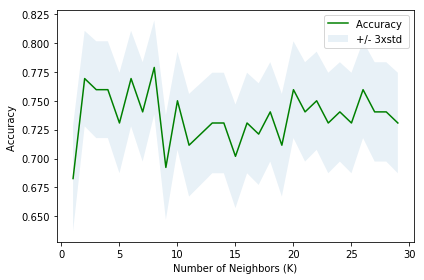

In [552]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [553]:
best_k = mean_acc.argmax()+1
print( "The best accuracy is with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
print( "The best accuracy using distance weights is with", mean_acc_dist_wgts.max(), "with k=", mean_acc_dist_wgts.argmax()+1) 

The best accuracy is with 0.7788461538461539 with k= 8
The best accuracy using distance weights is with 0.7596153846153846 with k= 6


## Use Best k to train model and get predictions

In [554]:
n = best_k
#Train Model and Predict  
neigh = KNeighborsClassifier(algorithm='auto',n_neighbors = n).fit(X_train,y_train)
neigh_dist_wgts = KNeighborsClassifier(algorithm='auto',n_neighbors = n,weights='distance',p=2).fit(X_train,y_train)
yhat_knn=neigh.predict(X_test)
yhat_dist_wgts_KNN=neigh_dist_wgts.predict(X_test)

## KNN Confusion Matrix

Accuracy: 0.7307692307692307
Precision: 0.23076923076923078
Recall: 0.14285714285714285
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        83
           1       0.23      0.14      0.18        21

   micro avg       0.73      0.73      0.73       104
   macro avg       0.52      0.51      0.51       104
weighted avg       0.69      0.73      0.71       104



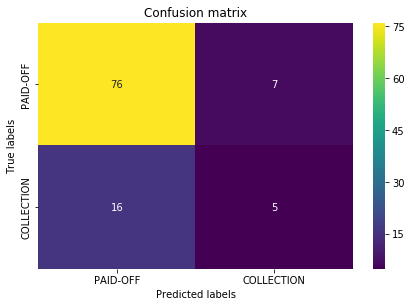

In [555]:
from sklearn.metrics import classification_report

cnf_matrix = metrics.confusion_matrix(y_test,yhat_knn,labels=[0,1])
cnf_matrix

class_names = ["PAID-OFF","COLLECTION"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g', ax=ax)
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names, va='center', rotation = 90, position=(0,0.28))

print("Accuracy:",metrics.accuracy_score(y_test, yhat_KNN))
print("Precision:",metrics.precision_score(y_test,yhat_KNN))
print("Recall:",metrics.recall_score(y_test,yhat_KNN))

print (classification_report(y_test,yhat_KNN))

# Decision Tree

In [556]:
from sklearn.tree import DecisionTreeClassifier

LoanTree = DecisionTreeClassifier(criterion="entropy",max_depth=4)
LoanTree # it shows the default parameters

print(np.unique(y_train))

[0 1]


In [557]:
LoanTree.fit(X_train,y_train)

yhat_dt = LoanTree.predict(X_test)

Nfeatures = np.size(X_test,axis=1)
print (yhat_dt [0:Nfeatures])
print (y_test [0:Nfeatures])

from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat_dt))

[0 0 0 0 0 0 0 0]
238    0
287    1
218    0
131    0
61     0
313    1
205    0
135    0
Name: loan_status, dtype: int64
DecisionTrees's Accuracy:  0.6538461538461539


## Decision Tree Confusion Matrix

Accuracy: 0.6538461538461539
Precision: 0.2413793103448276
Recall: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        83
           1       0.24      0.33      0.28        21

   micro avg       0.65      0.65      0.65       104
   macro avg       0.53      0.53      0.53       104
weighted avg       0.70      0.65      0.67       104



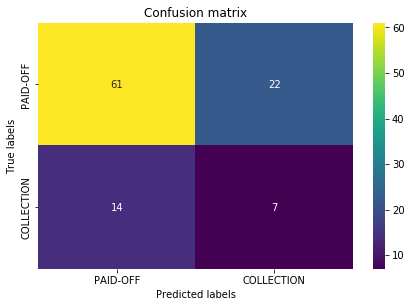

In [558]:
cnf_matrix = metrics.confusion_matrix(y_test, yhat_dt, labels=[0,1])
cnf_matrix

labels = ['business', 'health']

class_names = ["PAID-OFF","COLLECTION"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g', ax =ax)
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names, va='center', rotation = 90, position=(0,0.28))

print("Accuracy:",metrics.accuracy_score(y_test,  yhat_dt))
print("Precision:",metrics.precision_score(y_test, yhat_dt))
print("Recall:",metrics.recall_score(y_test,  yhat_dt))

print (classification_report(y_test, yhat_dt))



## Loan classifier involves skewed classes, i.e. Paid-off/Collection is un-balanced, we shall now apply balance weights and re-assess the performance of the decision tree classifier
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))


In [559]:
LoanTree_wgts = DecisionTreeClassifier(criterion="entropy",max_depth=4,class_weight="balanced")

LoanTree_wgts.fit(X_train,y_train)

yhat_dt_wgts = LoanTree_wgts.predict(X_test)

Nfeatures = np.size(X_test,axis=1)
print (yhat_dt_wgts [0:Nfeatures])
print (y_test [0:Nfeatures])

from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat_dt_wgts))

[0 1 0 0 1 0 0 0]
238    0
287    1
218    0
131    0
61     0
313    1
205    0
135    0
Name: loan_status, dtype: int64
DecisionTrees's Accuracy:  0.6057692307692307


## Decision Tree with class_weight option Confusion Matrix

Accuracy: 0.6057692307692307
Precision: 0.3076923076923077
Recall: 0.7619047619047619
              precision    recall  f1-score   support

           0       0.90      0.57      0.70        83
           1       0.31      0.76      0.44        21

   micro avg       0.61      0.61      0.61       104
   macro avg       0.61      0.66      0.57       104
weighted avg       0.78      0.61      0.64       104



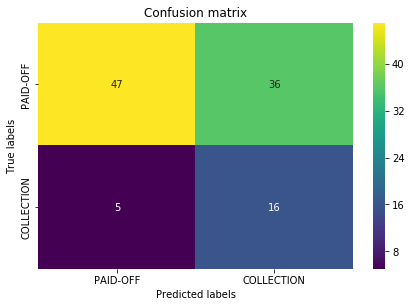

In [560]:
cnf_matrix = metrics.confusion_matrix(y_test, yhat_dt_wgts, labels=[0,1])
cnf_matrix

class_names = ["PAID-OFF","COLLECTION"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g', ax =ax)
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names, va='center', rotation = 90, position=(0,0.28))

print("Accuracy:",metrics.accuracy_score(y_test, yhat_dt_wgts))
print("Precision:",metrics.precision_score(y_test, yhat_dt_wgts))
print("Recall:",metrics.recall_score(y_test, yhat_dt_wgts))

print (classification_report(y_test, yhat_dt_wgts))

### Result: Weighting increased the accuracy of the model for predictions for the "Collection" class, but lessened the accuracy for the "Paid-Off" class. 

However, I will not apply class weights since it leads to poor performance of the model for each classifier.  Discussion on this can be found here: https://matloff.wordpress.com/2015/09/29/unbalanced-data-is-a-problem-no-balanced-data-is-worse/

## Trying Random Forest (Not part of lecture series)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

In [561]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestClassifier(bootstrap=True, criterion='entropy',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
forest_model.fit(X_train, y_train)
yhat_rf = forest_model.predict(X_test)
print(mean_absolute_error(y_test, yhat_rf))
score = forest_model.score(X_test, y_test)
print(score)
print(forest_model.feature_importances_)

0.20192307692307693
0.7980769230769231
[0.048941   0.11992711 0.18972823 0.09483704 0.39594918 0.04078943
 0.01895273 0.09087526]


## Random Forest Confusion Matrix

Accuracy: 0.7980769230769231
Precision: 0.0
Recall: 0.0
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        83
           1       0.00      0.00      0.00        21

   micro avg       0.80      0.80      0.80       104
   macro avg       0.40      0.50      0.44       104
weighted avg       0.64      0.80      0.71       104



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', 

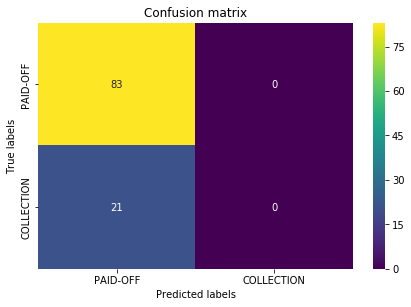

In [562]:
cnf_matrix = metrics.confusion_matrix(y_test, yhat_rf, labels=[0,1])
cnf_matrix

class_names = ["PAID-OFF","COLLECTION"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g', ax =ax)
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names, va='center', rotation = 90, position=(0,0.28))

print("Accuracy:",metrics.accuracy_score(y_test, yhat_rf))
print("Precision:",metrics.precision_score(y_test, yhat_rf))
print("Recall:",metrics.recall_score(y_test, yhat_rf))

print (classification_report(y_test, yhat_rf))

### Result: Random Forest classifier improved the Precision for 'Paid-off' class.

# Support Vector Machine

SVM features several options for building model classifer.  These options are referred to as hyperparameters, which are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes

https://scikit-learn.org/stable/modules/grid_search.html

Within scikit-learn, there are two generic approaches to sampling search candidates: for given values, GridSearchCV exhaustively considers all parameter combinations, while RandomizedSearchCV can sample a given number of candidates from a parameter space with a specified distribution.

Here, we try the exhaustive grid search approach, whereby candidates from a grid of parameter values specified with the param_grid parameter are generated. For instance, the following param_grid:

### Parameter estimation using grid search with cross-validation

In [563]:
# Set the parameters by cross-validation
svm_tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-2, 1e-1, 0.1],
                     'C': [1e-3, 1e-2, 1e-1, 0.1, 1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'gamma': [1e-3, 1e-2, 1e-1, 0.1],
                     'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}]

When “fitting” it on a dataset all the possible combinations of parameter values are evaluated and the best combination is retained.

In [564]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report  

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), svm_tuned_parameters,cv=4,
                       scoring='%s_macro' % score, n_jobs=-1)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()  


# Tuning hyper-parameters for precision



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.366 (+/-0.003) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.366 (+/-0.003) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.366 (+/-0.003) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.366 (+/-0.003) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.366 (+/-0.003) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.366 (+/-0.003) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.366 (+/-0.003) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.366 (+/-0.003) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.366 (+/-0.003) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.366 (+/-0.003) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.366 (+/-0.003) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.366 (+/-0.003) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.366 (+/-0.003) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.366 (+/-0.003) for {'C': 0.1, 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Using best hyper-parameters to build svc

In [565]:
print (clf.best_params_)
svm_best_values = clf.best_params_
print(svm_best_values)
svm_best_values.values()

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


dict_values([1000, 0.1, 'rbf'])

In [566]:
from sklearn import svm
svm_best = svm.SVC(**clf.best_params_)
svm_best.fit(X_train, y_train) 

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [567]:
yhat_svm = svm_best.predict(X_test)

## SVM Confusion Matrix

Accuracy: 0.7403846153846154
Precision: 0.40625
Recall: 0.6190476190476191
              precision    recall  f1-score   support

           0       0.89      0.77      0.83        83
           1       0.41      0.62      0.49        21

   micro avg       0.74      0.74      0.74       104
   macro avg       0.65      0.70      0.66       104
weighted avg       0.79      0.74      0.76       104



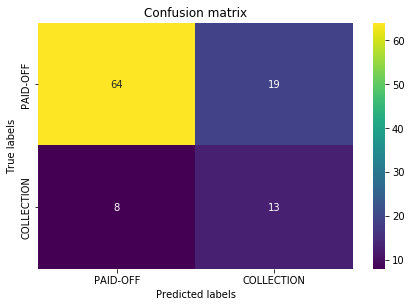

In [568]:
cnf_matrix = metrics.confusion_matrix(y_test, yhat_svm, labels=[0,1])
cnf_matrix

class_names = ["PAID-OFF","COLLECTION"]

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g', ax =ax)
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names, va='center', rotation = 90, position=(0,0.28))

print("Accuracy:",metrics.accuracy_score(y_test, yhat_svm))
print("Precision:",metrics.precision_score(y_test, yhat_svm))
print("Recall:",metrics.recall_score(y_test, yhat_svm))

print (classification_report(y_test, yhat_svm))

# Logistic Regression

### https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
 According to the documentation, this class has the following solvers: liblinear, newton-cg, sag, saga, lbfgs.  The ‘newton-cg’, ‘sag’, and ‘lbfgs’ solvers support only L2 regularization with primal formulation, or no regularization. The ‘liblinear’ solver supports both L1 and L2 regularization, with a dual formulation only for the L2 penalty. The Elastic-Net regularization is only supported by the ‘saga’ solver.
 Penalty: is used to specify the method of penalization of the coefficients of noncontributing variables.
 Lasso (L1) performs feature selection as it shrinks the less important feature’s coefficient to zero.
Ridge (L2) all variables are included in model, though some are shrunk. Less computationally intensive than lasso. 

As for the other classifiers, we will use "balanced" option to create class weights due to the imbalance between "Paid-off" and "Collection" classes.  

In [569]:
# Set the parameters by cross-validation
lr_tuned_parameters = [{'solver': ['newton-cg','lbfgs','sag'], 'penalty':['l2'],
                     'C': [1e-3, 1e-2, 1e-1, 0.1, 1, 10, 100, 1000]},
                    {'solver': ['liblinear','saga'], 'penalty':['l1'],
                     'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}]

In [570]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report  

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(fit_intercept=True), lr_tuned_parameters,cv=4,
                       scoring='%s_macro' % score, n_jobs=-1)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()  



# Tuning hyper-parameters for precision



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Grid scores on development set:

0.366 (+/-0.003) for {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
0.366 (+/-0.003) for {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
0.366 (+/-0.003) for {'C': 0.001, 'penalty': 'l2', 'solver': 'sag'}
0.366 (+/-0.003) for {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.366 (+/-0.003) for {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
0.366 (+/-0.003) for {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}
0.485 (+/-0.267) for {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.485 (+/-0.267) for {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.485 (+/-0.267) for {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
0.485 (+/-0.267) for {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.485 (+/-0.267) for {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.485 (+/-0.267) for {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
0.649 (+/-0.094) for {'C': 1, 'penalt

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Using best hyper-parameters to build Logistic Regression model

In [571]:
print (clf.best_params_)
lr_best_values = clf.best_params_
lr_best_values.values()

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


dict_values([1, 'l1', 'liblinear'])

In [572]:
lr_best=LogisticRegression(**clf.best_params_)
lr_best.fit(X_train, y_train) 

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [573]:
yhat_lr = clf_best.predict(X_test)

## Logistic Regression Confusion Matrix

Accuracy: 0.6057692307692307
Precision: 0.3333333333333333
Recall: 0.9523809523809523
              precision    recall  f1-score   support

           0       0.98      0.52      0.68        83
           1       0.33      0.95      0.49        21

   micro avg       0.61      0.61      0.61       104
   macro avg       0.66      0.74      0.59       104
weighted avg       0.85      0.61      0.64       104



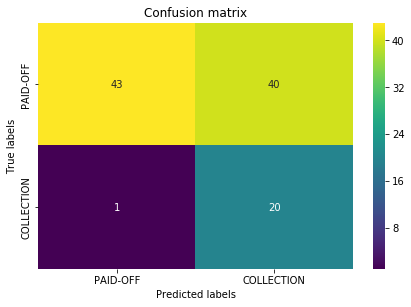

In [574]:
cnf_matrix = metrics.confusion_matrix(y_test, yhat_lr, labels=[0,1])
cnf_matrix

class_names = ["PAID-OFF","COLLECTION"]

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g', ax =ax)
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names, va='center', rotation = 90, position=(0,0.28))

print("Accuracy:",metrics.accuracy_score(y_test, yhat_lr))
print("Precision:",metrics.precision_score(y_test, yhat_lr))
print("Recall:",metrics.recall_score(y_test, yhat_lr))

print (classification_report(y_test, yhat_lr))

# Model Evaluation using Test set

In [575]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [576]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-10-13 14:37:33--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-10-13 14:37:33 (305 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [577]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Perform pre-processing steps as above

In [578]:
test_df['dayofweek'] = df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()



,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [586]:
X_test2 = Feature_test
X_test2[0:5]

y_test2 = test_df['loan_status'].values
print(y_test2[0:8])


y_int_test2=test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])
print(y_int_test2[0:8])

X_test2= preprocessing.StandardScaler().fit(X_test2).transform(X_test2)
X_test2[0:5]

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF']
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
Name: loan_status, dtype: int64


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:11: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -4.12310563,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054, -4.12310563,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211, -4.12310563,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.24253563,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.24253563,
         2.39791576, -0.79772404, -0.86135677]])

## Computing Jaccard Scores

In [587]:
yhat_test_knn=neigh.predict(X_test2)
jacc_ss_knn=jaccard_similarity_score(y_int_test2,yhat_test_knn)

yhat_test_dt = LoanTree.predict(X_test2)
jacc_ss_dt=jaccard_similarity_score(y_int_test2,yhat_test_dt)

yhat_test_rf = forest_model.predict(X_test2)
jacc_ss_rf=jaccard_similarity_score(y_int_test2,yhat_test_rf)

yhat_test_svm = svm_best.predict(X_test2)
jacc_ss_svm = jaccard_similarity_score(y_int_test2,yhat_test_svm)

yhat_test_lr = lr_best.predict(X_test2)
jacc_ss_lr=jaccard_similarity_score(y_int_test2,yhat_test_lr)
print('Jaccard Score:', 'KNN=', jacc_ss_knn,'DT=', jacc_ss_dt,'RF=', jacc_ss_rf,'SVM=',jacc_ss_svm,'LR=',jacc_ss_lr)

Jaccard Score: KNN= 0.7037037037037037 DT= 0.6851851851851852 RF= 0.7407407407407407 SVM= 0.6296296296296297 LR= 0.7407407407407407


## Computing F1 Scores

In [588]:
f1_score_knn = f1_score(y_int_test2, yhat_test_knn, average='weighted') 
f1_score_dt = f1_score(y_int_test2, yhat_test_dt, average='weighted') 
f1_score_rf = f1_score(y_int_test2, yhat_test_rf, average='weighted') 
f1_score_svm = f1_score(y_int_test2, yhat_test_svm, average='weighted') 
f1_score_lr = f1_score(y_int_test2, yhat_test_lr, average='weighted') 
print('F1 Score:', 'KNN=', f1_score_knn,'DT=', f1_score_dt, 'RF=', f1_score_rf, 'SVM=', f1_score_svm, 'LR=',f1_score_lr)

F1 Score: KNN= 0.6579124579124579 DT= 0.703520421830281 RF= 0.6304176516942475 SVM= 0.6430311890838205 LR= 0.6304176516942475


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Computing Logloss Score

In [585]:
yhat_lr_prob = lr_best.predict_proba(X_test2)
ll_score_lr = log_loss(y_int_test2, yhat_lr_prob)

print('Logloss Score:', 'LR=',ll_score_lr)

Logloss Score: LR= 0.5539632237470085


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.704       | 0.658        | NA      |
| Decision Tree      | 0.685       | 0.704        | NA      |
| SVM                | 0.630       | 0.643        | NA      |
| LogisticRegression | 0.741       | 0.630        | 0.554       |

## Final Comments
After much tinkering of the hyper-parameters in order to find the best model, I also found that best model selected depended on the random_state which sets up the training and test sets.
This should not be and I think that the only way to mitigate this dependence on random initialization is by increasing the sample size if it were possible.

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>